In [63]:
!mkdir ./tmp; cd ./tmp; wget "https://raw.githubusercontent.com/finiteloopme/quick-draw/main/categories/requested.txt"
!mkdir ./data
!mkdir ./model

mkdir: cannot create directory ‘./tmp’: File exists
--2022-07-04 20:17:24--  https://raw.githubusercontent.com/finiteloopme/quick-draw/main/categories/requested.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 759 [text/plain]
Saving to: ‘requested.txt.1’

requested.txt.1     100%[===================>]     759  --.-KB/s    in 0s      

2022-07-04 20:17:24 (57.9 MB/s) - ‘requested.txt.1’ saved [759/759]

mkdir: cannot create directory ‘./data’: File exists


In [40]:
def process_categories():
    f_categories = open("./tmp/requested.txt", "r")
    # Read each category from a line in the file
    categories = f_categories.readlines()
    # Remove newline char and replace SPACE with UNDERSCORE
    categories = [category.replace("\n", "").replace(" ", "_") for category in categories]
    f_categories.close()
    return categories
# pre_process_categories()

In [41]:
from urllib import request
def download_data(categories):
    base_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"
    for category in categories:
        category_uri = category.replace("_", "%20") + ".npy"
        request.urlretrieve(base_url+category_uri, "./data/"+category+".npy")

In [42]:
download_data(process_categories())

In [43]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

In [46]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [47]:
x_train, y_train, x_test, y_test, class_names = load_data('./data')
num_classes = len(class_names)
image_size = 28

In [48]:
print(len(x_train))

320000


laptop


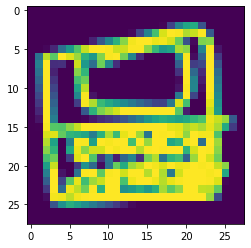

In [51]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

In [53]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [55]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(100, activation='softmax')) 
# Train model
# adam = tf.train.AdamOptimizer()
model.compile(loss='categorical_crossentropy',
              # optimizer=adam,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 3, 64)        

In [56]:
# training
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Epoch 1/5
1125/1125 - 92s - loss: 1.9067 - top_k_categorical_accuracy: 0.7844 - val_loss: 1.3940 - val_top_k_categorical_accuracy: 0.8741 - 92s/epoch - 81ms/step
Epoch 2/5
1125/1125 - 82s - loss: 1.2435 - top_k_categorical_accuracy: 0.8929 - val_loss: 1.1538 - val_top_k_categorical_accuracy: 0.9014 - 82s/epoch - 73ms/step
Epoch 3/5
1125/1125 - 85s - loss: 1.0796 - top_k_categorical_accuracy: 0.9105 - val_loss: 1.0733 - val_top_k_categorical_accuracy: 0.9124 - 85s/epoch - 75ms/step
Epoch 4/5
1125/1125 - 86s - loss: 0.9895 - top_k_categorical_accuracy: 0.9202 - val_loss: 0.9913 - val_top_k_categorical_accuracy: 0.9188 - 86s/epoch - 76ms/step
Epoch 5/5
1125/1125 - 86s - loss: 0.9284 - top_k_categorical_accuracy: 0.9260 - val_loss: 0.9503 - val_top_k_categorical_accuracy: 0.9232 - 86s/epoch - 76ms/step


In [57]:
# testing
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 92.32%


1/1 [==============================] - 0s 112ms/step
['hat', 'helmet', 'moustache', 'bread', 'laptop']


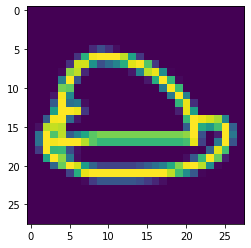

In [58]:
# Inference
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

In [59]:
with open('modelled.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

In [ ]:
!pip install tensorflowjs 

In [64]:
# Save model
model.save('keras.h5')

In [65]:
!tensorflowjs_converter --input_format keras keras.h5 ./model/

In [66]:
# Convert the model to TFlite for use with Flutter.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp12iux06p/assets


INFO:tensorflow:Assets written to: /tmp/tmp12iux06p/assets
2022-07-04 20:22:53.248280: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-07-04 20:22:53.248333: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-07-04 20:22:53.249309: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp12iux06p
2022-07-04 20:22:53.252057: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-07-04 20:22:53.252086: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmp12iux06p
2022-07-04 20:22:53.254507: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-04 20:22:53.260491: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is n